# FACTORING AND ORDER FINDING 

## Todor Krasimirov Ivanov

### INTRODUCTION
The factorization of an integer number belongs to the set of NP problems because it cannot be deterministically solved in polynomial time by a classical computer. This problem cannot be efficiently solved even in a quantum computer, however, it can be reduced to order-finding problem which is known to be solved efficiently by a quantum computer.

The order-finding algorithm is a quantum algorithm used to find the order of an element $x$ in a cyclic group $G$, where the order of an element is the smallest positive integer $r$ such that $x^r = i$ with $i$ being the identity element of $G$. Given that the factoring problem is related to the modulus operation and the modulus operation is a cyclic group, the factoring problem of an integer $N$ can be represented as an order-finding problem for some element $x$ coprime with $N$ (otherwise, the factors are already found) where the order is the smallest positive integer $r$ such that $x^r = 1\, mod\, N$.

The most famous quantum algorithm, Shor's algorithm, solves efficiently the factorization problem by using the order-finding of some random integer $x \in (1,N-1)$ where $N$ is the number to be factored.

Shor's algorithm is composed by a working register $t$ that controls the application of some unitary operator $U_N |k⟩ |1⟩ = |k⟩ |x^k mod N⟩$ to a target register where the modulus exponentiation operation will be stored. The working register state is prepared as a uniform superposition of all possible states, then it controls the said unitary operator and the inverse Quantum Fourier Transform (QFT$^†$) is performed in order to obtain the possible periods of repetition $r$ of $|x^k mod N⟩$.

### PROCESS OF FACTORING

Once the period $r$ of a randomly chosen base $x$ has been found, it can be used it to compute the factors of $N$ using a classical algorithm.

Let's say that r is an even number, and there is a non-trivial factorization of $N$, $N=p \cdot q$, where $p$ and $q$ are prime factors of $N$. In this case, the following two equations are found:

$x^r = 1\, mod\,N$

$(x^{r/2} - 1)(x^{r/2} + 1) = 0\, mod\, N$

From these two equations, the following two possibilities are derived:

$x^{r/2} = -1\,mod\,N$
or
$x^{r/2} = 1\,mod\,N$

In the first case:

$(x^{r/2} + 1)\cdot(x^{r/2} - 1) = 0 \,mod\,N$

Since $x^{r/2} = -1\,mod\,N$:

$(x^{r/2} + 1)(x^{r/2} + 1) = 0\,mod\,N$

So, at the end:

$x^r + 1 = 0\,mod\,N$

This means that N divides $x^r + 1$, and since $x^r = 1\,mod\,N$, we have:

$x^r + 1 = 2\,mod\,N$

Therefore, we can write:

$N = gcd(x^{r/2} + 1, N) * gcd(x^{r/2} - 1, N)$

Since $r$ in known and $x^{r/2}\,mod\,N$ can be computed, classical algorithms can be used such as the continued fraction algorithm or Euclidean algorithm to find the gcd of $x^{r/2} + 1$ and $N$, and the gcd of $x^{r/2} - 1$ and $N$. These gcds will give the factors of N, p and q in an ideal case. If one of the two values is a non-trivial factor of $N$ (i.e. different than $1$ or $N$), then the factors of $N$ are found. Otherwise, the factors are not found because $r$ is not the actual period and a different $x$ should be chosen or the size of the register $t$ should be increased to find the real period and, thus, the factors of $N$.

### SIMULATION OF THE ALGORITHM

For Shor's algorithm, the forementioned oracle $U_N$ needs to be implemented for the order to be successfully found. It can be implemented with universal quantum gates so $U_N |k⟩ |1⟩ = |k⟩ |x^k mod N⟩$. Instead of building this oracle, the state will be straightly prepared depending on the randomly-chosen $x$, the number to be factorized $N$ and the number of qubits involved in the circuit. Also, the inverse QFT function is also provided for the last stage of the algorithm.

Next, all the needed libraries and methods are defined in order to simulate the Shor's algorithm and obtain the final factors of a given integer $N$. To simulate the quantum circuit, _qiskit_ software development kit is used.

Several simulations are performed with different values of $t$, $x$ and $N$ aiming to see the behavior of the quantum algorithm.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
pd.set_option('display.max_columns', None)
from fractions import Fraction
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def get_coeffs(x, N, n_q, n_count):
    vec = np.zeros(2**n_q)
    base = 1
    for i in range(2**n_count):
        s1 = np.binary_repr(i,n_count)
        mod2 = np.mod(base,N)
        base = mod2*x
        s2 = np.binary_repr(mod2,n_q-n_count)
        print(i,mod2,s1,s2)
        vec[int(s2+s1,2)] = 1
    return vec

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def q_period_finding(x, N, n_q, n_count):
    #Prepare the state after modular exponentiation
    vec = get_coeffs(x, N, n_q, n_count)
    vec = np.multiply(vec, 1/np.sqrt(2**n_count))

    #Prepare the quantum circuit
    Q = QuantumCircuit(n_q,n_count)

    Q.initialize(vec)

    Q.append(qft_dagger(n_count),range(n_count))
    Q.measure(range(n_count),range(n_count))
    #Q.draw(fold=-1)  # -1 means 'do not fold'

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(Q, aer_sim)
    qobj = assemble(t_qc)
    results = aer_sim.run(qobj).result()
    return results.get_counts()

def continuous_fraction_reduction(counts, x, N, n_count):
    rows, measured_phases = [], []
    for output in counts:
        decimal = int(output, 2)  # Convert (base 2) string to decimal
        phase = decimal/(2**n_count)  # Find corresponding eigenvalue
        measured_phases.append(phase)
        # Add these values to the rows in our table:
        frac = Fraction(phase).limit_denominator(N)
        #rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{decimal}/{2**n_count} = {phase:.2f}",f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", f"{frac.numerator}/{frac.denominator}", frac.denominator, np.gcd(x**(frac.denominator//2)-1, N), np.gcd(x**(frac.denominator//2)+1, N)])
    # Print the rows in a table
    #headers=["Register Output", "Phase", "Fraction", "Guess for r", "guess1","guess2"]
    headers=["Register Output", "Fraction", "Guess for r", "guess1","guess2"]
    return pd.DataFrame(rows, columns=headers)

For a first simulation example, lets choose $N = 11*3 = 33$, $x = 5$ and size of $t=4$. 

0 1 0000 00000001
1 5 0001 00000101
2 25 0010 00011001
3 26 0011 00011010
4 31 0100 00011111
5 23 0101 00010111
6 16 0110 00010000
7 14 0111 00001110
8 4 1000 00000100
9 20 1001 00010100
10 1 1010 00000001
11 5 1011 00000101
12 25 1100 00011001
13 26 1101 00011010
14 31 1110 00011111
15 23 1111 00010111


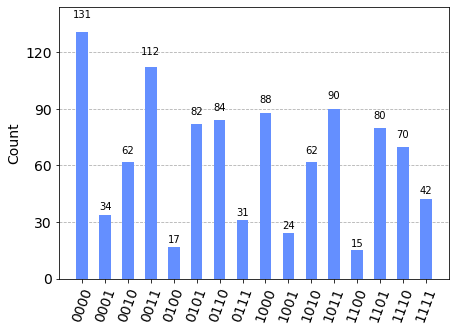

In [2]:
x = 5
N = 33
n_q = 12 # total number of Qubits (QFT_register + x**k_register)
n_count = 4 # number of qubits of QFT_register

counts = q_period_finding(x, N, n_q, n_count)
plot_histogram(counts)

In [3]:
df = continuous_fraction_reduction(counts, x, N, n_count)
print(df)

possible_factors = [i for i in df.iloc[:,3] if (i!=1 and i!=N)]
possible_factors = possible_factors + [i for i in df.iloc[:,4] if (i!=1 and i!=N)]
print('\nNON-TRIVIAL FACTORS: ')
print(possible_factors)

         Register Output Fraction  Guess for r  guess1  guess2
0   1010(bin) =  10(dec)      5/8            8       3       1
1   1001(bin) =   9(dec)     9/16           16       3       1
2   0001(bin) =   1(dec)     1/16           16       3       1
3   0011(bin) =   3(dec)     3/16           16       3       1
4   1000(bin) =   8(dec)      1/2            2       1       3
5   0101(bin) =   5(dec)     5/16           16       3       1
6   1110(bin) =  14(dec)      7/8            8       3       1
7   0110(bin) =   6(dec)      3/8            8       3       1
8   1101(bin) =  13(dec)    13/16           16       3       1
9   0010(bin) =   2(dec)      1/8            8       3       1
10  1111(bin) =  15(dec)    15/16           16       3       1
11  0000(bin) =   0(dec)      0/1            1      33       1
12  0100(bin) =   4(dec)      1/4            4       3       1
13  1100(bin) =  12(dec)      3/4            4       3       1
14  1011(bin) =  11(dec)    11/16           16       3 

In this case, the period gives a non-trivial factor of $3$. Immediately after, the other factor $11$ can be found ($33/3 = 11$).

### WORKING REGISTER ANALYSIS
The size of the working register $t$ used to store the working qubits has some constraints during the QFT and the modular exponentiation function. The size of the register must be such that:

 1. The number of qubits in the register must be big enough to represent all possible values of the period $r$ that could be measured. In general, the number of qubits needed for the register is at least 2 times the number of bits in N so, if we want to represent all possible values of r using k bits, we need to have $2^k ≥ N$. Taking the logarithm of both sides, we get $k ≥ log_2(N)$. However, in Shor's algorithm, we need to represent not only the possible values of $r$, but also the superposition of all possible values of $r$. This leads to the requirement of using $2k$ qubits for the working register in order to ensure the obtaining of the correct period $r$.


 2. The size of the register must be chosen such that the modular exponentiation function is periodic with high probability for at least one period length smaller than $N$. This requirement limits the number of qubits in the register, as it is related to the efficiency of the modular exponentiation function.


### CHOICE OF THE MODULAR EXPONENTIATION ANALYSIS

The decision of the random base $x$ of the modular exponentation have some effects that one has to take into account to make the best choices in order to avoid the algorithm's failure.

 1. If the measured period $r$ at the end of the quantum algorithm results to be an odd number, the algorithm fails because $x^{r/2}$ won't be an integer number unless $x$ is a perfect square. Therefore, one has to change the chosen $x$. 
 2. In general, the chosen value of $x$ has to be coprime with $N$, i.e. $gcd(x,N) = 1$ because, otherwise, the modular exponentiation $x^k \, mod \, N$ will not have a well-defined period an there's risk of failure in the factorization, however, there's a high probability of not getting an $x$ such that $gcd(x,N) ≠ 1$ and, if this happens, $x$ is already one of the factors of $N$.
 
In practice, the best choice of $x$ in order to increase the algorithm's probability of success is a small prime number or a primitive root modulo N but, generally, it can be randomly chosen between the range $(1, N-1)$.

One __remarkable__ thing is that $t$ register size and the $x$ selection are closely related to each other. When the period $r$ of modular-exponentiating $x$ (number of times exponentiation was performed in order to obtain two identical results) can be represented by the register $t$, then the algorithm will work and factors can be obtained. If the register $t$ is not big enough to represent the number of exponentiations done to find a periodic result, the algorithm will fail to obtain the factors of $N$.

Nevertheless, it is always possible to obtain a correct factor of $N$ even though the working register's size is not able to store the period of modular exponentiation. This is because the measurement is probabilistic so, some of the obtained periods in $t$ register can result into $N ≠ gcd(x^{r/2} \pm 1,N) ≠ 1$ but the there is no actual defined period in the measurements.

Let's show experimentally the previously described constraints by testing different examples of $N$, $x$ and size of $t$.

#### Example with an insufficient size of register $t$ that gives no solution
Let's choose the parameters $N=17\cdot23 = 143$, $x=6$ and a $t$ size of $7$ ($n\_counts$ in code).

For $t$ equal $7$, the working register will not find the modular exponentiation periodicity of $x=28$ because the register $t$ does not fulfill the general condition of being twice the number of bits needed to represent $N$.


0 1 0000000 000000001
1 28 0000001 000011100
2 69 0000010 001000101
3 73 0000011 001001001
4 42 0000100 000101010
5 32 0000101 000100000
6 38 0000110 000100110
7 63 0000111 000111111
8 48 0001000 000110000
9 57 0001001 000111001
10 23 0001010 000010111
11 72 0001011 001001000
12 14 0001100 000001110
13 106 0001101 001101010
14 108 0001110 001101100
15 21 0001111 000010101
16 16 0010000 000010000
17 19 0010001 000010011
18 103 0010010 001100111
19 24 0010011 000011000
20 100 0010100 001100100
21 83 0010101 001010011
22 36 0010110 000100100
23 7 0010111 000000111
24 53 0011000 000110101
25 54 0011001 000110110
26 82 0011010 001010010
27 8 0011011 000001000
28 81 0011100 001010001
29 123 0011101 001111011
30 12 0011110 000001100
31 50 0011111 000110010
32 113 0100000 001110001
33 18 0100001 000010010
34 75 0100010 001001011
35 98 0100011 001100010
36 27 0100100 000011011
37 41 0100101 000101001
38 4 0100110 000000100
39 112 0100111 001110000
40 133 0101000 010000101
41 6 0101001 000000110

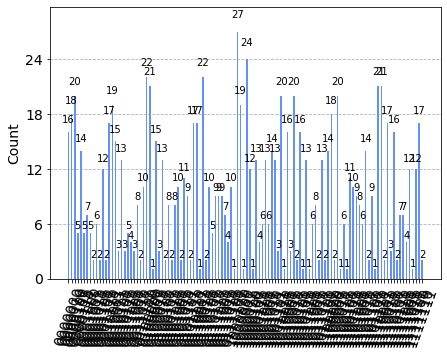

In [4]:
x = 28
N = 143
n_q = 16 # total number of Qubits (QFT_register + x**k_register)
n_count = 7 # number of qubits of QFT_register

counts = q_period_finding(x, N, n_q, n_count)
plot_histogram(counts)

In [5]:
df = continuous_fraction_reduction(counts, x, N, n_count)
print(df)
possible_factors = [i for i in df.iloc[:,3] if (i!=1 and i!=N)]
possible_factors = possible_factors + [i for i in df.iloc[:,4] if (i!=1 and i!=N)]

print('\nNON-TRIVIAL FACTORS: ')
print(possible_factors)

             Register Output Fraction  Guess for r  guess1  guess2
0    1101101(bin) = 109(dec)  109/128          128       1       1
1    0010001(bin) =  17(dec)   17/128          128       1       1
2    1000110(bin) =  70(dec)    35/64           64       1       1
3    1111100(bin) = 124(dec)    31/32           32       1       1
4    0000000(bin) =   0(dec)      0/1            1     143       1
..                       ...      ...          ...     ...     ...
109  1111111(bin) = 127(dec)  127/128          128       1       1
110  1101100(bin) = 108(dec)    27/32           32       1       1
111  1010100(bin) =  84(dec)    21/32           32       1       1
112  1101110(bin) = 110(dec)    55/64           64       1       1
113  0100001(bin) =  33(dec)   33/128          128       1       1

[114 rows x 5 columns]

NON-TRIVIAL FACTORS: 
[]


Nevertheless, taking instead a size of $t=8$, the factors are successfully computed without even needing to fulfill the condition of twice the size needed to represent $N$ but enough for the chosen parameters.

0 1 00000000 00000001
1 28 00000001 00011100
2 69 00000010 01000101
3 73 00000011 01001001
4 42 00000100 00101010
5 32 00000101 00100000
6 38 00000110 00100110
7 63 00000111 00111111
8 48 00001000 00110000
9 57 00001001 00111001
10 23 00001010 00010111
11 72 00001011 01001000
12 14 00001100 00001110
13 106 00001101 01101010
14 108 00001110 01101100
15 21 00001111 00010101
16 16 00010000 00010000
17 19 00010001 00010011
18 103 00010010 01100111
19 24 00010011 00011000
20 100 00010100 01100100
21 83 00010101 01010011
22 36 00010110 00100100
23 7 00010111 00000111
24 53 00011000 00110101
25 54 00011001 00110110
26 82 00011010 01010010
27 8 00011011 00001000
28 81 00011100 01010001
29 123 00011101 01111011
30 12 00011110 00001100
31 50 00011111 00110010
32 113 00100000 01110001
33 18 00100001 00010010
34 75 00100010 01001011
35 98 00100011 01100010
36 27 00100100 00011011
37 41 00100101 00101001
38 4 00100110 00000100
39 112 00100111 01110000
40 133 00101000 10000101
41 6 00101001 00000110

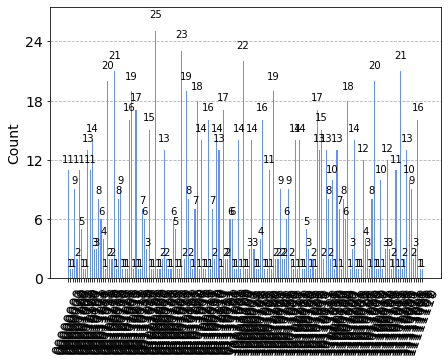

In [6]:
n_count = 8 # number of qubits of QFT_register

counts = q_period_finding(x, N, n_q, n_count)
plot_histogram(counts)

In [7]:
df = continuous_fraction_reduction(counts, x, N, n_count)
print(df)
possible_factors = [i for i in df.iloc[:,3] if (i!=1 and i!=N)]
possible_factors = possible_factors + [i for i in df.iloc[:,4] if (i!=1 and i!=N)]

print('\nNON-TRIVIAL FACTORS: ')
print(possible_factors)

              Register Output Fraction  Guess for r  guess1  guess2
0    00011110(bin) =  30(dec)   15/128          128       1       1
1    00111100(bin) =  60(dec)    15/64           64       1       1
2    10010101(bin) = 149(dec)    39/67           67       1       1
3    11010010(bin) = 210(dec)  105/128          128       1       1
4    01001011(bin) =  75(dec)    29/99           99       1       1
..                        ...      ...          ...     ...     ...
158  10001010(bin) = 138(dec)   69/128          128       1       1
159  10011011(bin) = 155(dec)   66/109          109       1      13
160  00110100(bin) =  52(dec)    13/64           64       1       1
161  11010100(bin) = 212(dec)    53/64           64       1       1
162  10001100(bin) = 140(dec)    35/64           64       1       1

[163 rows x 5 columns]

NON-TRIVIAL FACTORS: 
[11, 11, 13, 11, 13, 13, 11, 13, 11, 11, 13, 11, 11, 13, 11, 11, 13, 11, 11, 13, 11, 13, 11, 11, 11, 11, 13, 11, 13, 13]


#### Example when chosen $x$ is not coprime with $N$

In order to show that period-finding does not work when $x$ and $N$ are not coprimes even with a great size of $t$, the chosen parameters will be $N=17*7=119$, $x = 17$ one of the factors of $N$ and $t = 6$.

0 1 000000 0000000001
1 17 000001 0000010001
2 51 000010 0000110011
3 34 000011 0000100010
4 102 000100 0001100110
5 68 000101 0001000100
6 85 000110 0001010101
7 17 000111 0000010001
8 51 001000 0000110011
9 34 001001 0000100010
10 102 001010 0001100110
11 68 001011 0001000100
12 85 001100 0001010101
13 17 001101 0000010001
14 51 001110 0000110011
15 34 001111 0000100010
16 102 010000 0001100110
17 68 010001 0001000100
18 85 010010 0001010101
19 17 010011 0000010001
20 51 010100 0000110011
21 34 010101 0000100010
22 102 010110 0001100110
23 68 010111 0001000100
24 85 011000 0001010101
25 17 011001 0000010001
26 51 011010 0000110011
27 34 011011 0000100010
28 102 011100 0001100110
29 68 011101 0001000100
30 85 011110 0001010101
31 17 011111 0000010001
32 51 100000 0000110011
33 34 100001 0000100010
34 102 100010 0001100110
35 68 100011 0001000100
36 85 100100 0001010101
37 17 100101 0000010001
38 51 100110 0000110011
39 34 100111 0000100010
40 102 101000 0001100110
41 68 101001 0001000

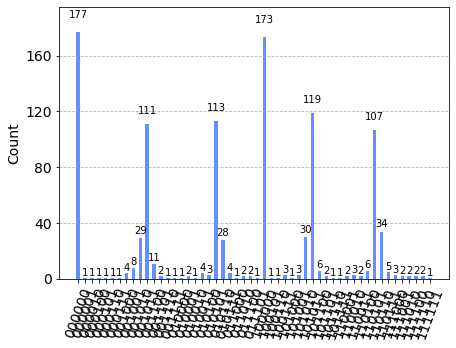

In [8]:
x = 17
N = 119
n_q = 16 # total number of Qubits (QFT_register + x**k_register)
n_count = 6 # number of qubits of QFT_register

counts = q_period_finding(x, N, n_q, n_count)
plot_histogram(counts)

In [9]:
df = continuous_fraction_reduction(counts, x, N, n_count)
print(df)

possible_factors = [i for i in df.iloc[:,3] if (i!=1 and i!=N)]
possible_factors = possible_factors + [i for i in df.iloc[:,4] if (i!=1 and i!=N)]
print('\nNON-TRIVIAL FACTORS: ')
print(possible_factors)

           Register Output Fraction  Guess for r  guess1  guess2
0   010011(bin) =  19(dec)    19/64           64       1       1
1   000010(bin) =   2(dec)     1/32           32       1       1
2   110101(bin) =  53(dec)    53/64           64       1       1
3   101011(bin) =  43(dec)    43/64           64       1       1
4   111110(bin) =  62(dec)    31/32           32       1       1
5   001011(bin) =  11(dec)    11/64           64       1       1
6   010101(bin) =  21(dec)    21/64           64       1       1
7   111100(bin) =  60(dec)    15/16           16       1       1
8   001101(bin) =  13(dec)    13/64           64       1       1
9   001100(bin) =  12(dec)     3/16           16       1       1
10  000001(bin) =   1(dec)     1/64           64       1       1
11  101010(bin) =  42(dec)    21/32           32       1       1
12  110110(bin) =  54(dec)    27/32           32       1       1
13  100000(bin) =  32(dec)      1/2            2       1       1
14  001000(bin) =   8(dec

There are no non-trivial factors found when $x$ is a factor of $N$.

However, using the same values as before and using a non-factor of $N$, $x=15$, the period is defined as seen in the following histogram and the factors $7$ and $17$ of $N=119$ are found:

0 1 000000 0000000001
1 15 000001 0000001111
2 106 000010 0001101010
3 43 000011 0000101011
4 50 000100 0000110010
5 36 000101 0000100100
6 64 000110 0001000000
7 8 000111 0000001000
8 1 001000 0000000001
9 15 001001 0000001111
10 106 001010 0001101010
11 43 001011 0000101011
12 50 001100 0000110010
13 36 001101 0000100100
14 64 001110 0001000000
15 8 001111 0000001000
16 1 010000 0000000001
17 15 010001 0000001111
18 106 010010 0001101010
19 43 010011 0000101011
20 50 010100 0000110010
21 36 010101 0000100100
22 64 010110 0001000000
23 8 010111 0000001000
24 1 011000 0000000001
25 15 011001 0000001111
26 106 011010 0001101010
27 43 011011 0000101011
28 50 011100 0000110010
29 36 011101 0000100100
30 64 011110 0001000000
31 8 011111 0000001000
32 1 100000 0000000001
33 15 100001 0000001111
34 106 100010 0001101010
35 43 100011 0000101011
36 50 100100 0000110010
37 36 100101 0000100100
38 64 100110 0001000000
39 8 100111 0000001000
40 1 101000 0000000001
41 15 101001 0000001111
42 106 1

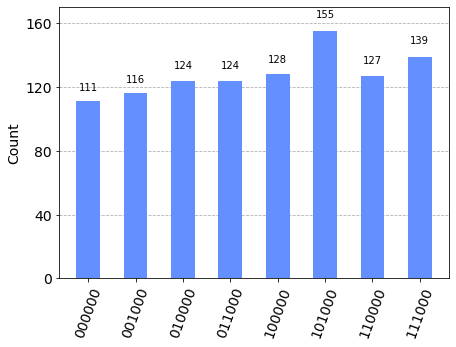

In [10]:
x = 15

counts = q_period_finding(x, N, n_q, n_count)
plot_histogram(counts)

In [11]:
df = continuous_fraction_reduction(counts, x, N, n_count)
print(df)

possible_factors = [i for i in df.iloc[:,3] if (i!=1 and i!=N)]
possible_factors = possible_factors + [i for i in df.iloc[:,4] if (i!=1 and i!=N)]
print('\nNON-TRIVIAL FACTORS: ')
print(possible_factors)

          Register Output Fraction  Guess for r  guess1  guess2
0  111000(bin) =  56(dec)      7/8            8       7      17
1  110000(bin) =  48(dec)      3/4            4       7       1
2  100000(bin) =  32(dec)      1/2            2       7       1
3  001000(bin) =   8(dec)      1/8            8       7      17
4  000000(bin) =   0(dec)      0/1            1     119       1
5  101000(bin) =  40(dec)      5/8            8       7      17
6  010000(bin) =  16(dec)      1/4            4       7       1
7  011000(bin) =  24(dec)      3/8            8       7      17

NON-TRIVIAL FACTORS: 
[7, 7, 7, 7, 7, 7, 7, 17, 17, 17, 17]


### MEASUREMENT REQUIREMENTS

When measuring the working register $t$ at the end of the quantum algorithm, there are chances of not getting the period (or a multiple) of the modular exponentiation. Therefore, multiple measurements are required in order to know if each outcome corresponds to the correct period (or multiple).

The probability of measuring an actual period of the modular exponentiation depends on the number $N$ to be factored and the size of the register $t$, assuming that the gates and the measurements are ideal (otherwise, more errors are introduced). It also depends on the chosen base $x$ because its modular exponentiation can find the period easier or harder depending on its value.

However, in general, it takes a constant number of iterations of the algorithm to successfully find the factors of $N$. This is because the order-finding algorithm will give the correct order $r$ with $P(r) > \frac{384}{\pi^6} \approx 0.399$ and, else, the measured value will be a multiple of $r$ or a fail because of the measured value is odd.

### COMPUTATIONAL COST

The computational cost of the factoring algorithm can be split into two parts: the quantum complexity and the classical post-processing of the measured result (the period $r$). 

On one hand, the quantum algorithm complexity depends on the implementation of the modular exponentiation, the number $N$ to be factorized, the size of the working register $t$ where the inverse Quantum Fourier Transform will be applied.
 1. The QFT requires the order of $O((log N)^2)$ elementary quantum gates.
 2. The modular exponentiation can be implemented by fast multiplication (do the modulus before multiplying) which would give an order of $O((log N)\,log\,log(N) log\,log\,log(N))$. As the modular exponentiation controlled unitaries has to be applied $log(N)$ times, the overall needed elementary gates is in the order of $O((log N)^2\,log\,log(N) log\,log\,log(N))$.
 
Therefore, the __computational complexity of the order-finding quantum algorithm is in $O((log N)^2\,log\,log(N) log\,log\,log(N))$.__

On the other hand, the classical post-processing complexity to find the factors from the measured period can vary depending on the used algorithm. In this assignment, the continued fraction algorithm was used and it has a complexity of $O(t^2)$ because of the measured period $r$ size. In other words, __the computational complexity of continued fraction algorithm is typically in $O(log N)$.__

### BIBLIOGRAPHY

1. [An introduction to quantum computing. Philip Kaye, Raymond Laflamme, Michele Mosca.](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149125645.pdf)